In [18]:
# Install necessary packages
!pip install pyspark==3.5.1 tensorflow==2.15.0 keras==2.15.0 scikit-learn==1.2.2 imbalanced-learn==0.10.1 scikeras


1. Import Necessary Packages

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from imblearn.over_sampling import SMOTE
import joblib

2. Initialize Spark Session

In [20]:
# Initialize Spark Session
spark = SparkSession.builder.appName("WeatherPrediction").getOrCreate()

3. Load Data

In [21]:
# Load data
train_data = spark.read.csv("data/Weather-Training-Data.csv", header=True, inferSchema=True)
test_data = spark.read.csv("data/Weather-Test-Data.csv", header=True, inferSchema=True)

4. Show a Few Rows

In [22]:
# Show the first 5 rows of both training & testing datasets
train_data.show(5)
test_data.show(5)

+------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|row ID|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|  Row0|  Albury|   13.4|   22.9|     0.6|       NULL|    NULL|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|    NULL|   16.9|   21.8|       No|           0|
|  Row1|  Albury|    7.4|   

5. Data Schema

In [23]:
# Print the schema of both training & testing datasets
train_data.printSchema()
test_data.printSchema()

root
 |-- row ID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- Evaporation: double (nullable = true)
 |-- Sunshine: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: integer (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: integer (nullable = true)
 |-- WindSpeed3pm: integer (nullable = true)
 |-- Humidity9am: integer (nullable = true)
 |-- Humidity3pm: integer (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- Cloud9am: integer (nullable = true)
 |-- Cloud3pm: integer (nullable = true)
 |-- Temp9am: double (nullable = true)
 |-- Temp3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: integer (nullable = true)

root
 |-- row ID: string (nullab

6. Count Missing Values

In [24]:
def missing_value_summary(df):
    total_rows = df.count()

    # Calculate missing values for each column
    missing_counts = df.select([
        count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns
    ])

    # Convert to Pandas
    missing_counts_pd = missing_counts.toPandas().T
    missing_counts_pd.columns = ["Missing_Count"]
    missing_counts_pd["Total_Rows"] = total_rows
    missing_counts_pd["Non_Missing_Count"] = total_rows - missing_counts_pd["Missing_Count"]
    missing_counts_pd["Missing_Percentage"] = (missing_counts_pd["Missing_Count"] / total_rows * 100).round(2).astype(str) + '%'

    # Display the formatted DataFrame
    print("Missing Values Summary:")
    print(missing_counts_pd)

# Display missing values summary
print("Missing Values Summary for Training Data:")
missing_value_summary(train_data)
print("Missing Values Summary for Testing Data:")
missing_value_summary(test_data)


Missing Values Summary for Training Data:
Missing Values Summary:
               Missing_Count  Total_Rows  Non_Missing_Count Missing_Percentage
row ID                     0       99516              99516               0.0%
Location                   0       99516              99516               0.0%
MinTemp                  443       99516              99073              0.45%
MaxTemp                  230       99516              99286              0.23%
Rainfall                 979       99516              98537              0.98%
Evaporation            42531       99516              56985             42.74%
Sunshine               47317       99516              52199             47.55%
WindGustDir                0       99516              99516               0.0%
WindGustSpeed           6480       99516              93036              6.51%
WindDir9am                 0       99516              99516               0.0%
WindDir3pm                 0       99516              99516      

7. Summary Statistics

In [25]:
# Convert to Pandas DataFrame
train_data_to_pd = train_data.toPandas()
test_data_to_pd = test_data.toPandas()


In [26]:
# Summary statistics for training & testing datasets
print("Summary Statistics for Training Data:")
print(train_data_to_pd.describe())
print("Summary Statistics for Testing Data:")
print(test_data_to_pd.describe())


Summary Statistics for Training Data:
            MinTemp       MaxTemp      Rainfall  Evaporation      Sunshine  \
count  99073.000000  99286.000000  98537.000000  56985.00000  52199.000000   
mean      12.176266     23.218513      2.353024      5.46132      7.615090   
std        6.390882      7.115072      8.487866      4.16249      3.783008   
min       -8.500000     -4.100000      0.000000      0.00000      0.000000   
25%        7.600000     17.900000      0.000000      2.60000      4.800000   
50%       12.000000     22.600000      0.000000      4.80000      8.400000   
75%       16.800000     28.200000      0.800000      7.40000     10.600000   
max       33.900000     48.100000    371.000000     86.20000     14.500000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   93036.000000  98581.000000  97681.000000  98283.000000  97010.000000   
mean       39.976966     14.004849     18.650464     68.866376     51.433296   
std        13.58152

8. Visualize Categorical Column Distributions

In [27]:
numerical_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

<ipython-input-28-48585bb035e5>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
<ipython-input-28-48585bb035e5>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


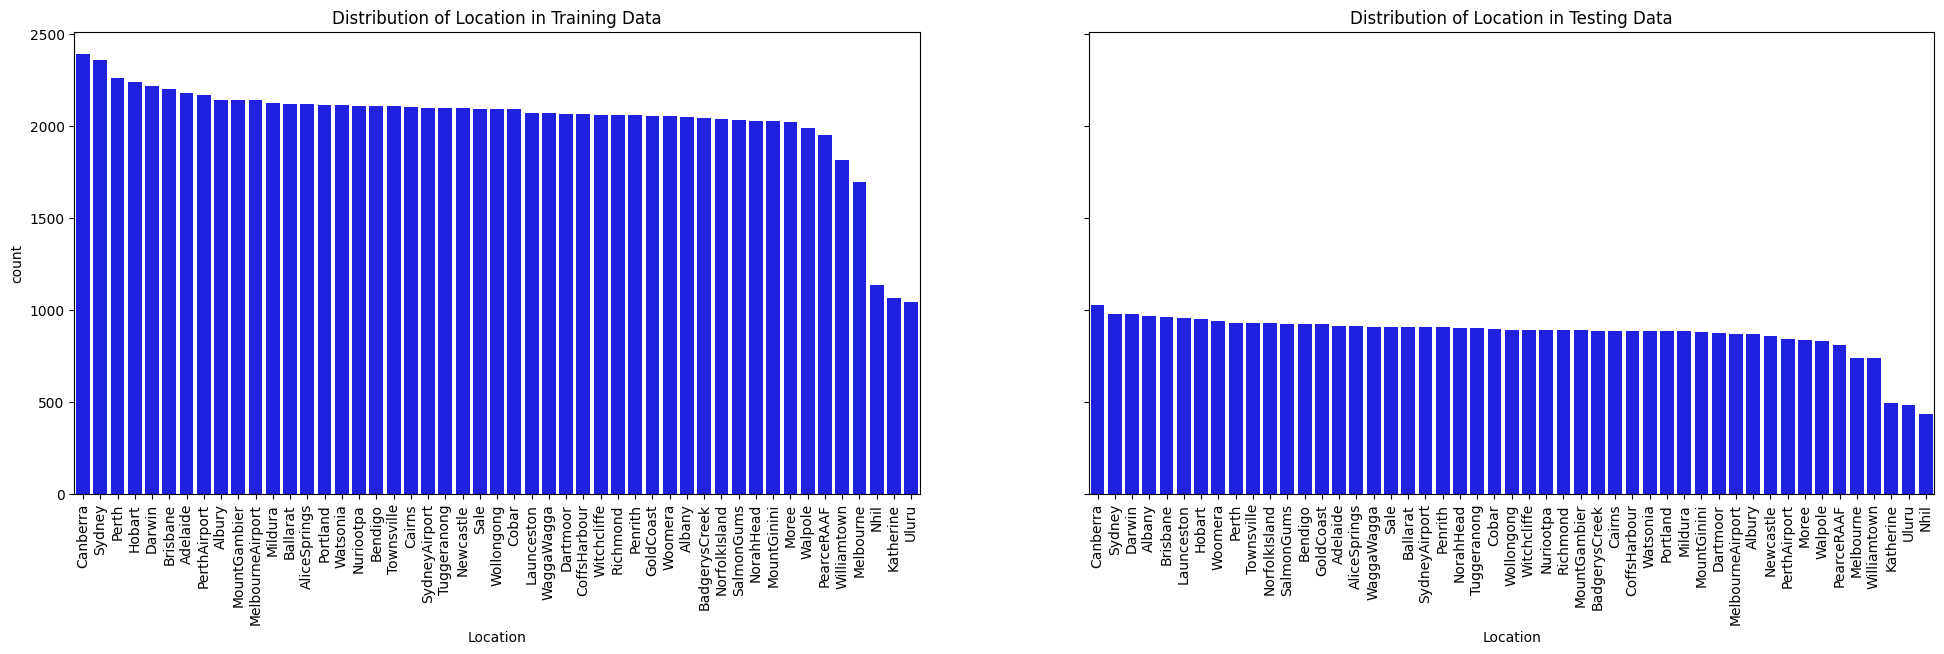

<ipython-input-28-48585bb035e5>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
<ipython-input-28-48585bb035e5>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


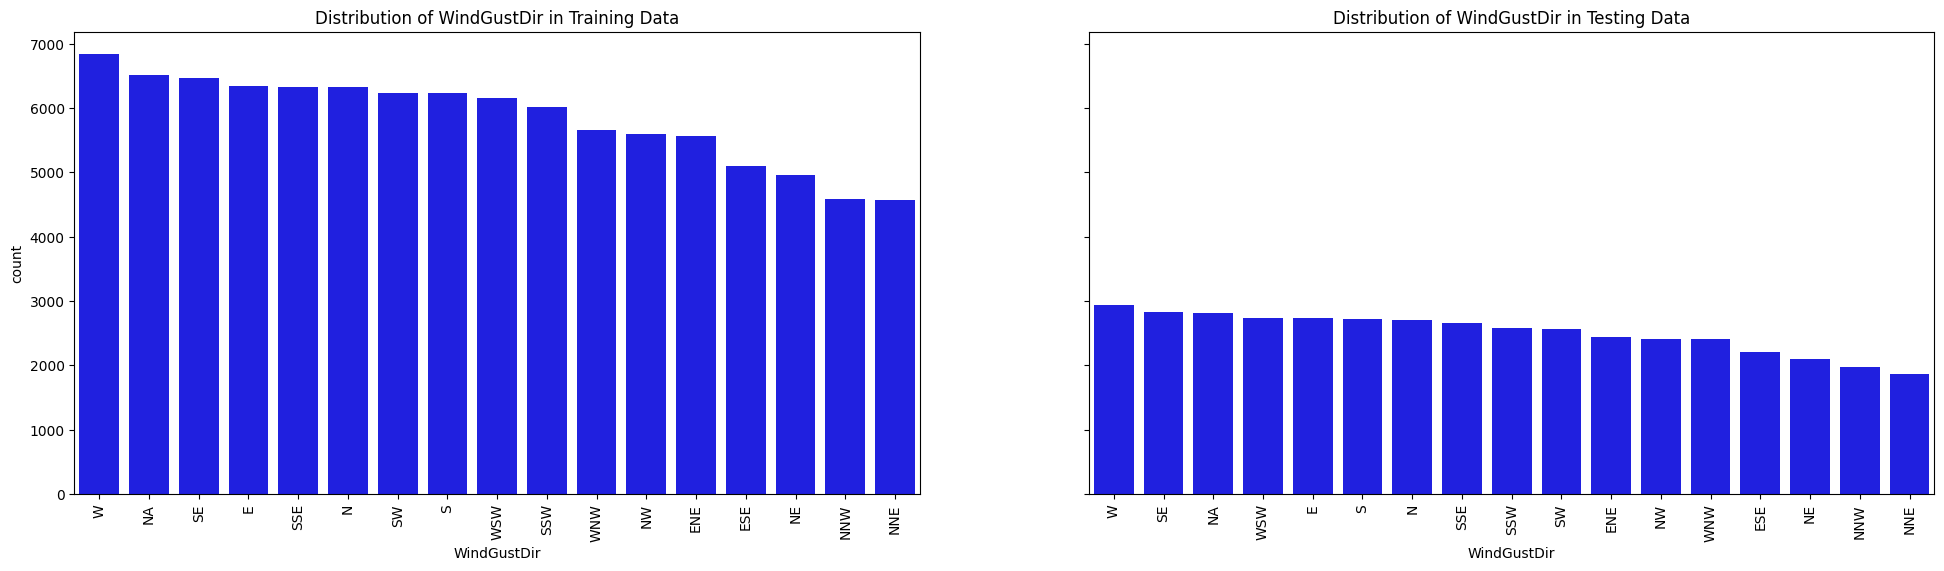

<ipython-input-28-48585bb035e5>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
<ipython-input-28-48585bb035e5>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


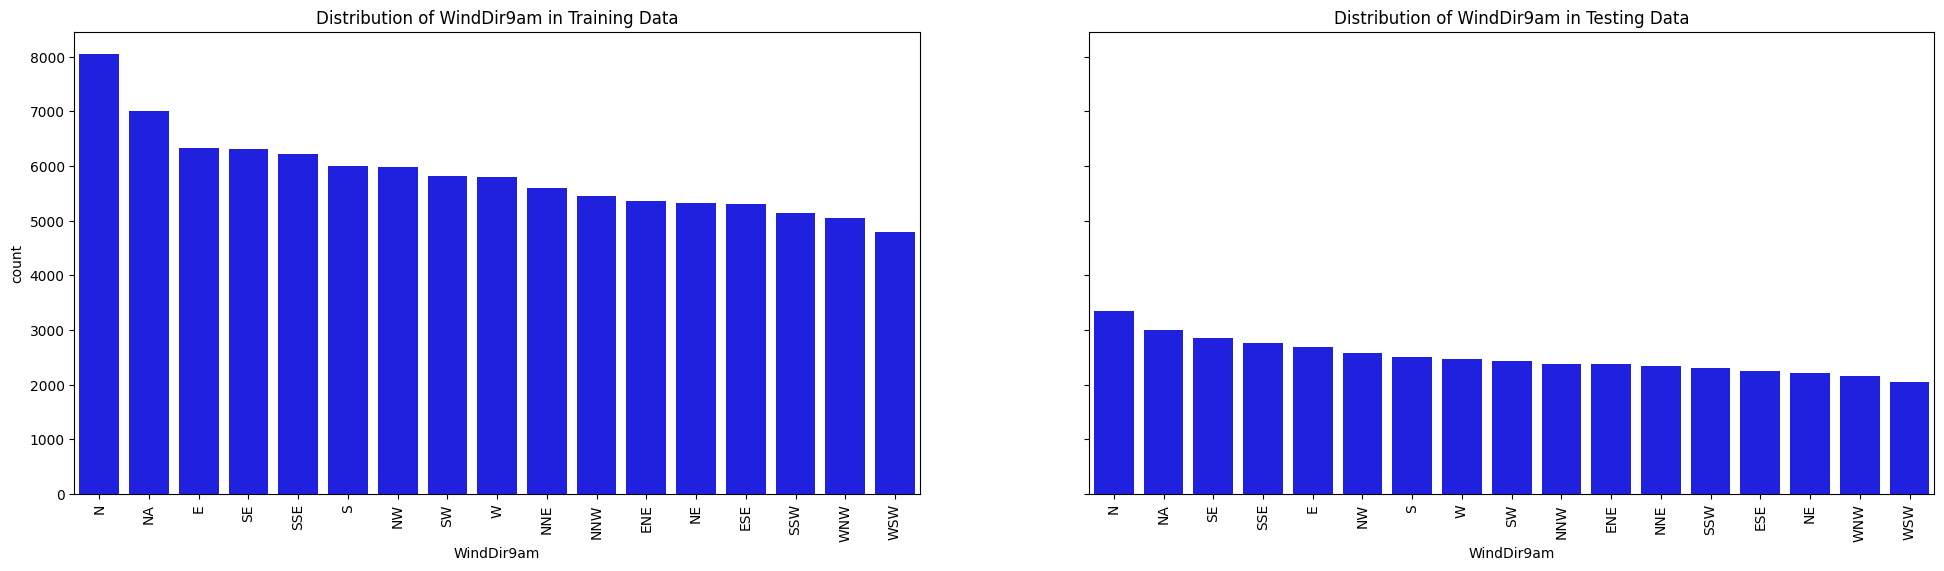

<ipython-input-28-48585bb035e5>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
<ipython-input-28-48585bb035e5>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


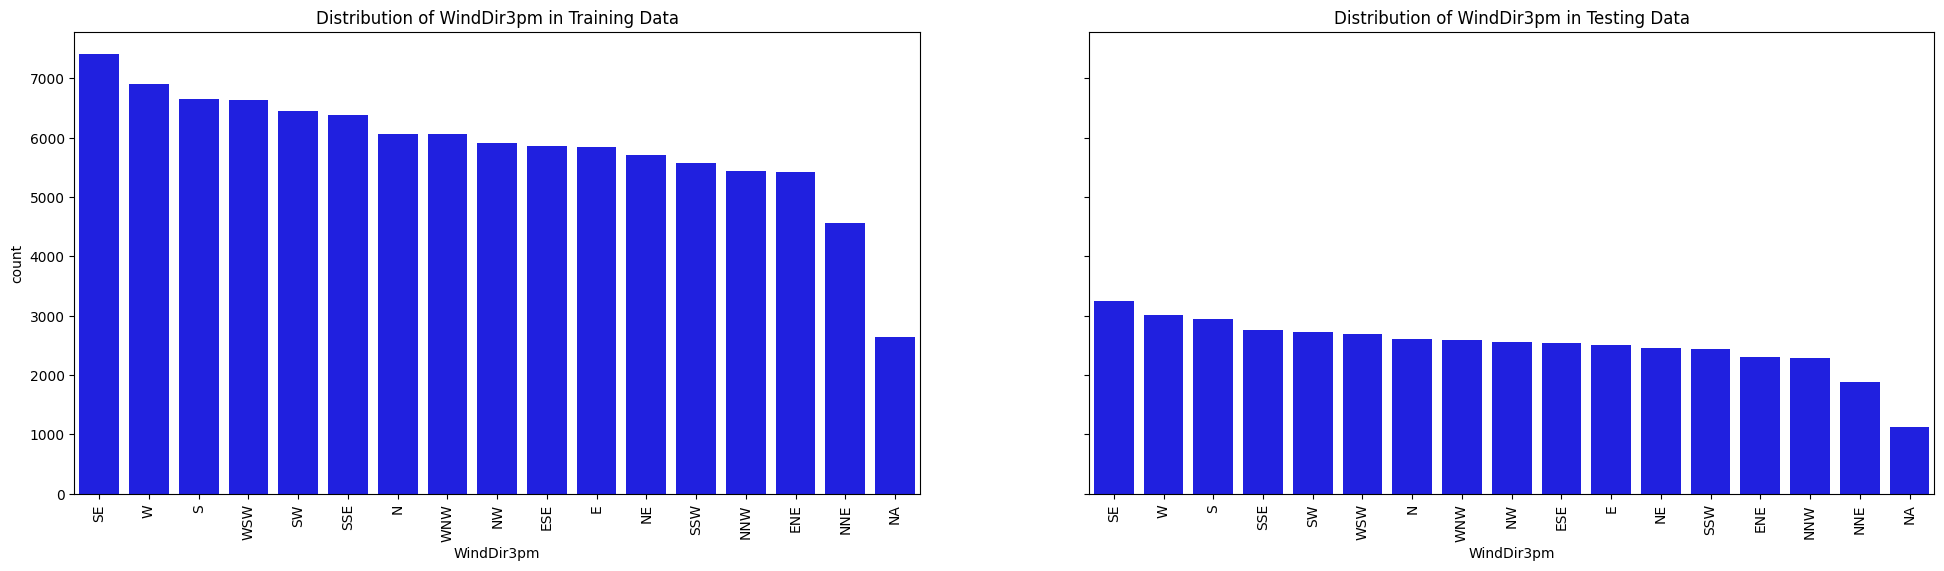

In [28]:
# Plot categorical columns distribution
def plot_categorical_distribution_side_by_side(train_df, test_df, cols):
    for col in cols:
        train_data = train_df.groupby(col).size().reset_index(name='count').sort_values(by='count', ascending=False)
        test_data = test_df.groupby(col).size().reset_index(name='count').sort_values(by='count', ascending=False)

        fig, axes = plt.subplots(1, 2, figsize=(24, 6), sharey=True)

        sns.barplot(x=train_data[col], y=train_data['count'], color='blue', ax=axes[0])
        axes[0].set_title(f"Distribution of {col} in Training Data")
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

        sns.barplot(x=test_data[col], y=test_data['count'], color='blue', ax=axes[1])
        axes[1].set_title(f"Distribution of {col} in Testing Data")
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

        plt.show()


plot_categorical_distribution_side_by_side(train_data_to_pd, test_data_to_pd, categorical_cols)


9. Preprocess Data

In [29]:
# Fill missing values for numerical columns with mean and for categorical columns with mode
for col_name in numerical_cols:
    mean_value = train_data.select(col_name).agg({col_name: "mean"}).first()[0]
    train_data = train_data.na.fill({col_name: mean_value})
    test_data = test_data.na.fill({col_name: mean_value})

for col_name in categorical_cols:
    mode_value = train_data.groupBy(col_name).count().orderBy('count', ascending=False).first()[0]
    train_data = train_data.na.fill({col_name: mode_value})
    test_data = test_data.na.fill({col_name: mode_value})

# Handle 'RainToday' separately
train_data = train_data.withColumn('RainToday', col('RainToday').cast('string'))
test_data = test_data.withColumn('RainToday', col('RainToday').cast('string'))

train_data_pd = train_data.toPandas()
test_data_pd = test_data.toPandas()

# Convert 'RainToday' to binary values
label_encoder = LabelEncoder()
train_data_pd['RainToday'] = label_encoder.fit_transform(train_data_pd['RainToday'])
test_data_pd['RainToday'] = label_encoder.transform(test_data_pd['RainToday'])

# Print the first 5 rows of Spark DataFrames to check data
print("Train Data (first 5 rows):")
train_data.show(5)
print("Test Data (first 5 rows):")
test_data.show(5)


Train Data (first 5 rows):
+------+--------+-------+-------+--------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|row ID|Location|MinTemp|MaxTemp|Rainfall|      Evaporation|         Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+------+--------+-------+-------+--------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|  Row0|  Albury|   13.4|   22.9|     0.6|5.461319645520799|7.615090327400943|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1

10. Prepare Input and Output Variables

In [30]:
# Columns to exclude and features to keep
exclude_columns = ['row ID']
features = [col for col in train_data_pd.columns if col not in exclude_columns + ['RainTomorrow']]


X = train_data_pd[features]
y = train_data_pd['RainTomorrow'].values.astype(np.float32)

# Split data for validation and training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


11. Preprocess Data and Apply SMOTE

In [31]:
# Preprocessing for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)

# Preprocessing pipeline for training data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(test_data_pd[features])

# Apply SMOTE after preprocessing
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Class distribution after SMOTE:", np.bincount(y_train_sm.astype(int)))

# Convert sparse matrices to dense
X_train_sm = X_train_sm.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()


Class distribution after SMOTE: [61755 61755]


12. Define Model Building Function

In [32]:
# Define the model building function
def build_model(dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_sm.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


13. Set Up and Fit RandomizedSearchCV

In [33]:
# Create the KerasClassifier
model = KerasClassifier(model=build_model, verbose=0)

# Parameter grid for RandomizedSearchCV
param_grid = {
    'model__dropout_rate': [0.3, 0.4, 0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64, 128],
    'epochs': [50, 100]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=1, verbose=3)

# Fit the random search model
random_search_result = random_search.fit(X_train_sm, y_train_sm)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END batch_size=128, epochs=100, model__dropout_rate=0.5, model__optimizer=rmsprop;, score=0.811 total time= 3.6min
[CV 2/3] END batch_size=128, epochs=100, model__dropout_rate=0.5, model__optimizer=rmsprop;, score=0.875 total time= 4.4min
[CV 3/3] END batch_size=128, epochs=100, model__dropout_rate=0.5, model__optimizer=rmsprop;, score=0.874 total time= 3.6min
[CV 1/3] END batch_size=64, epochs=50, model__dropout_rate=0.3, model__optimizer=rmsprop;, score=0.805 total time= 3.4min
[CV 2/3] END batch_size=64, epochs=50, model__dropout_rate=0.3, model__optimizer=rmsprop;, score=0.883 total time= 2.6min
[CV 3/3] END batch_size=64, epochs=50, model__dropout_rate=0.3, model__optimizer=rmsprop;, score=0.878 total time= 2.6min
[CV 1/3] END batch_size=128, epochs=50, model__dropout_rate=0.4, model__optimizer=adam;, score=0.808 total time= 2.4min
[CV 2/3] END batch_size=128, epochs=50, model__dropout_rate=0.4, model__optimizer

14. Get Best Parameters

In [34]:
# Print the best parameters
best_params = random_search_result.best_params_
print("Best parameters found: ", best_params)


Best parameters found:  {'model__optimizer': 'adam', 'model__dropout_rate': 0.3, 'epochs': 100, 'batch_size': 128}


15. Build and Train new Model with Best Parameters

In [35]:
# Build a new model with the best parameters
model = build_model(dropout_rate=best_params['model__dropout_rate'], optimizer=best_params['model__optimizer'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the best parameters
history = model.fit(X_train_sm, y_train_sm, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stopping])


Epoch 1/100
965/965 [==============================] - 7s 5ms/step - loss: 0.4529 - accuracy: 0.7903 - val_loss: 0.4135 - val_accuracy: 0.8052
Epoch 2/100
965/965 [==============================] - 4s 5ms/step - loss: 0.4052 - accuracy: 0.8176 - val_loss: 0.4161 - val_accuracy: 0.7993
Epoch 3/100
965/965 [==============================] - 6s 6ms/step - loss: 0.3823 - accuracy: 0.8316 - val_loss: 0.3933 - val_accuracy: 0.8144
Epoch 4/100
965/965 [==============================] - 4s 5ms/step - loss: 0.3637 - accuracy: 0.8409 - val_loss: 0.3794 - val_accuracy: 0.8214
Epoch 5/100
965/965 [==============================] - 4s 4ms/step - loss: 0.3503 - accuracy: 0.8476 - val_loss: 0.3956 - val_accuracy: 0.8169
Epoch 6/100
965/965 [==============================] - 6s 6ms/step - loss: 0.3391 - accuracy: 0.8535 - val_loss: 0.3867 - val_accuracy: 0.8219
Epoch 7/100
965/965 [==============================] - 4s 5ms/step - loss: 0.3305 - accuracy: 0.8578 - val_loss: 0.3909 - val_accuracy: 0.8250

16. Plot Training History

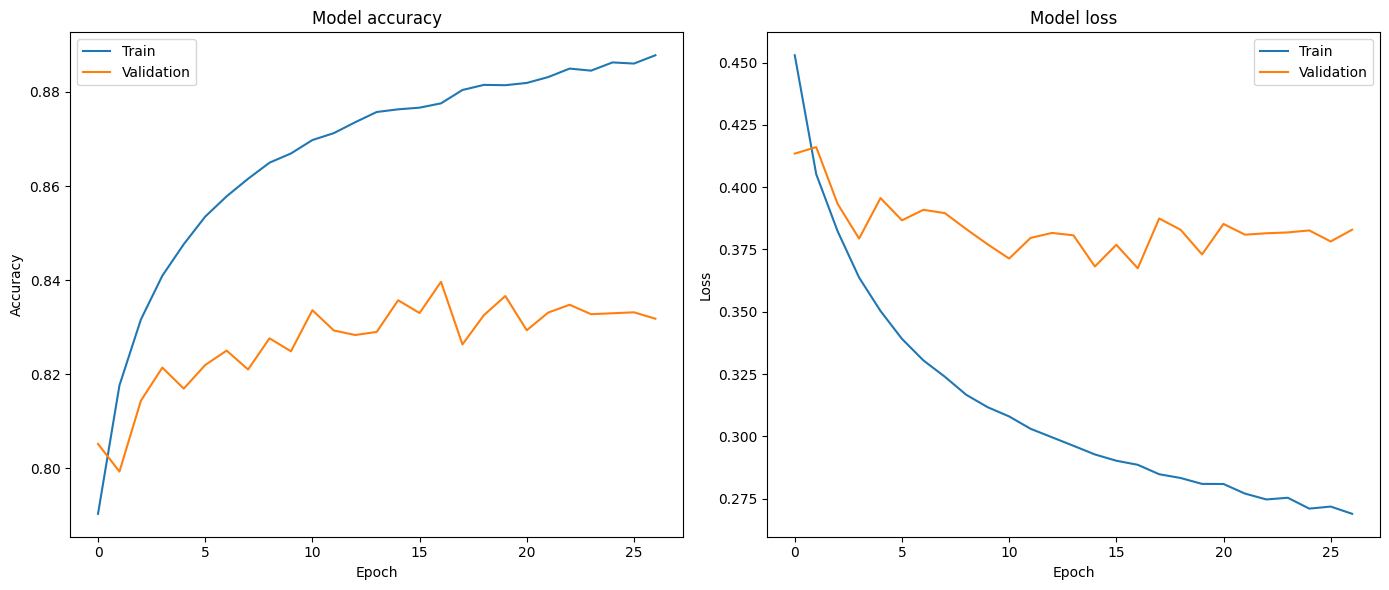

In [36]:
# Plot training history
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


17. Evaluate the Model

622/622 [==============================] - 1s 2ms/step - loss: 0.3674 - accuracy: 0.8396
Neural Network Accuracy on validation data: 0.8396302461624146
622/622 [==============================] - 1s 2ms/step


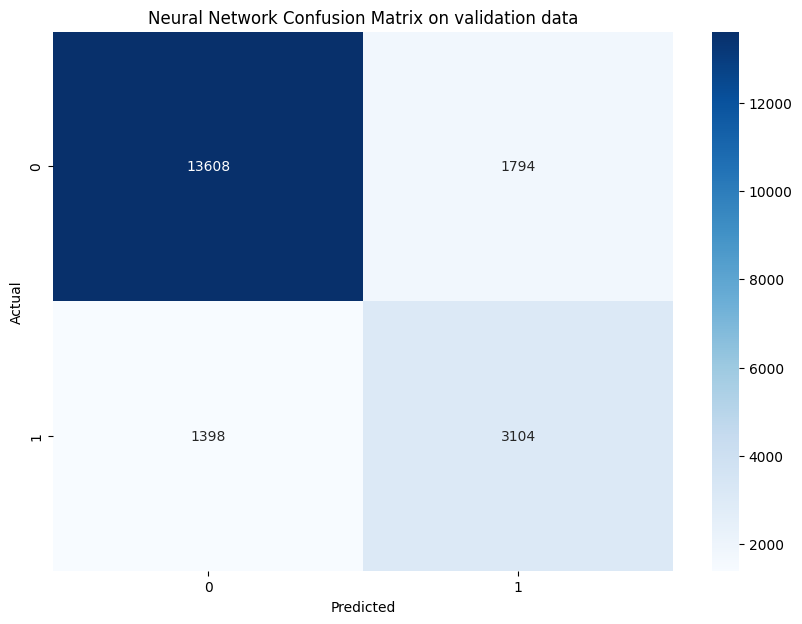

In [37]:
# Evaluate the model on the validation data
loss_nn, accuracy_nn = model.evaluate(X_val, y_val)
print(f'Neural Network Accuracy on validation data: {accuracy_nn}')

# Make predictions on the validation data
y_pred_nn = (model.predict(X_val) > 0.5).astype("int32")

# Plot confusion matrix
conf_matrix_nn = confusion_matrix(y_val, y_pred_nn)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues')
plt.title('Neural Network Confusion Matrix on validation data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


18. Classification report

In [38]:
# Classification report
print(classification_report(y_val, y_pred_nn))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90     15402
         1.0       0.63      0.69      0.66      4502

    accuracy                           0.84     19904
   macro avg       0.77      0.79      0.78     19904
weighted avg       0.85      0.84      0.84     19904


19. Save the best Model

In [46]:
# Save the model
model.save('best_model.h5')
print("Model saved as best_model.h5")


# Save the Preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocessor saved as preprocessor.pkl")


Model saved as best_model.h5
Preprocessor saved as preprocessor.pkl


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
